<a href="https://colab.research.google.com/github/kooose38/visualization-for-attention/blob/master/attention_encoder_decoder_6a7ab_4896_402e_bdd4_5b10899ad.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Encoder Decoder による再起型文章生成タスク
目的: アテンションを可視化することで文章生成におけるネットワークの説明性を学習します。  
環境: python3.7.11 google-colab  
パッケージ: [requirements.txt](https://github.com/kooose38/visualization-for-attention/blob/master/requirements.txt)  
参照: [https://qiita.com/m__k/items/646044788c5f94eadc8d](https://qiita.com/m__k/items/646044788c5f94eadc8d)

### load dataset 

In [26]:
filename = "data.txt"
inputs, labels = [], []

with open(filename, "r") as f:
  data_list = f.readlines()
  for data in data_list:
    data = data[:-1]
    inputs.append(data.split("_")[0])
    labels.append("_"+data.split("_")[1])

import pandas as pd 

df = pd.DataFrame({"before": inputs, "after": labels})
df.sample(10)

,before,after
46193,"jan 15, 1986",_1986-01-15
42691,"DEC 20, 1990",_1990-12-20
31692,"Monday, December 12, 2016",_2016-12-12
4927,"august 29, 2005",_2005-08-29
24780,"FEB 28, 1983",_1983-02-28
44525,"june 20, 1985",_1985-06-20
18554,"APRIL 27, 2002",_2002-04-27
31363,12/31/06,_2006-12-31
49566,"mar 2, 1986",_1986-03-02
47664,"APRIL 19, 2010",_2010-04-19


In [27]:
word2index = {}
for inp, lab in zip(inputs, labels):
  for i in inp:
    if i not in word2index:
      word2index[i] = len(word2index)
  for t in lab:
    if t not in word2index:
      word2index[t] = len(word2index)

print(word2index)

{'s': 0, 'e': 1, 'p': 2, 't': 3, 'm': 4, 'b': 5, 'r': 6, ' ': 7, '2': 8, '7': 9, ',': 10, '1': 11, '9': 12, '4': 13, '_': 14, '-': 15, '0': 16, 'A': 17, 'u': 18, 'g': 19, '3': 20, '8': 21, '/': 22, 'T': 23, 'U': 24, 'E': 25, 'S': 26, 'D': 27, 'Y': 28, 'P': 29, 'M': 30, 'B': 31, 'R': 32, '5': 33, 'J': 34, 'N': 35, '6': 36, 'a': 37, 'i': 38, 'l': 39, 'O': 40, 'c': 41, 'o': 42, 'G': 43, 'F': 44, 'y': 45, 'n': 46, 'C': 47, 'W': 48, 'd': 49, 'I': 50, 'L': 51, 'j': 52, 'H': 53, 'v': 54, 'h': 55, 'V': 56, 'f': 57, 'w': 58}


### preprocessing

In [28]:
import torch
dataset = []

for inp, lab in zip(inputs, labels):
  data = {}
  input_ids = []
  labels_ids = []
  for i in inp:
    idx = word2index[i]
    input_ids.append(idx)
  for l in lab:
    idx = word2index[l]
    labels_ids.append(idx)

  data["input_ids"] = torch.tensor(input_ids, dtype=torch.long) 
  data["labels"] = torch.tensor(labels_ids, dtype=torch.long)
  dataset.append(data)


In [29]:
n_ = len(dataset)
n_train = int(n_*.6)
n_val = int(n_*.2)

train_ds, val_ds, test_ds = dataset[:n_train], dataset[n_train:n_train+n_val], dataset[n_train+n_val:]

from torch.utils.data import DataLoader 

train = DataLoader(train_ds, batch_size=100, shuffle=True)
val = DataLoader(val_ds, batch_size=100, shuffle=True)
test = DataLoader(test_ds, batch_size=100, shuffle=True)

In [34]:
for r in train:
  print(r["input_ids"].size()) # (batch, encoder_token)
  print(r["labels"].size()) # (batch, decoder_token)
  print(r["input_ids"])
  print(r["labels"])
  break

torch.Size([100, 29])
torch.Size([100, 11])
tensor([[48,  1, 49,  ..., 12, 21, 16],
        [30, 37, 45,  ...,  7,  7,  7],
        [26,  1,  2,  ...,  7,  7,  7],
        ...,
        [23, 18,  1,  ...,  7,  7,  7],
        [34, 37, 46,  ...,  7,  7,  7],
        [23, 24, 25,  ...,  7,  7,  7]])
tensor([[14, 11, 12,  ..., 15, 11,  9],
        [14, 11, 12,  ..., 15,  8, 36],
        [14,  8, 16,  ..., 15, 16, 13],
        ...,
        [14, 11, 12,  ..., 15, 11, 33],
        [14, 11, 12,  ..., 15, 16, 20],
        [14, 11, 12,  ..., 15, 16, 12]])


### Model

##### Encoder layers


In [16]:
import torch.nn as nn 

class Encoder(nn.Module):
  def __init__(self, embedding_dim, hidden_dim, vocab_size, intermediate_size=1024):
    super(Encoder, self).__init__()
    self.hidden_dim = hidden_dim
    
    self.embed = nn.Embedding(vocab_size, embedding_dim, padding_idx=word2index[" "])
    self.lstm = nn.LSTM(embedding_dim, hidden_dim, batch_first=True)

    self.fc = nn.Sequential(
        nn.Linear(embedding_dim, hidden_dim),
        nn.Dropout(.1),
        nn.LayerNorm(hidden_dim)
    )
    self.norm = nn.LayerNorm(hidden_dim)

    self.fc1 = nn.Sequential(
        nn.Linear(hidden_dim, intermediate_size),
        nn.Dropout(.1),
        nn.LayerNorm(intermediate_size),
        nn.Linear(intermediate_size, hidden_dim),
        nn.GELU(),
    )

  def forward(self, x):
    '''
    x: encoder-input-ids (batch, encoder-token)

    hs: encoder-all-hidden (batch, encoder-token, hidden_dim)
    output: encoder-last-token-hidden (batch, hidden_dim) 1 token
    '''
    x = self.embed(x)
    hs, out = self.lstm(x)
    out = out[0].view(-1, self.hidden_dim) # 最後の系列トークンベクトル

    xx = x[:, -1, :].view(-1, x.size()[2])
    xx = self.fc(xx)

    out1 = self.norm(xx+out)
    out2 = self.fc1(out1)

    output = self.norm(out2+out)

    return output, hs 

In [18]:
net = Encoder(100, 20, len(word2index))

a = torch.rand(1, 12).long()
y, hs = net(a)
print(y.size())
print(hs.size())

torch.Size([1, 20])
torch.Size([1, 12, 20])


#### Decoder layers

In [84]:
class Decoder(nn.Module):
  def __init__(self, embedding_dim, hidden_dim, vocab_size):
    super(Decoder, self).__init__()
    self.embedding_dim = embedding_dim
    self.hidden_dim = hidden_dim 

    self.embed = nn.Embedding(vocab_size, embedding_dim, padding_idx=word2index[" "])

    self.i2h = nn.Linear(embedding_dim+hidden_dim, hidden_dim)
    self.i2hs = nn.Linear(embedding_dim+hidden_dim, hidden_dim)
    self.i2o = nn.Linear(embedding_dim+hidden_dim, hidden_dim)

    self.softmax = nn.Softmax(dim=1)

    self.o2o = nn.Sequential(
        nn.Linear(hidden_dim+hidden_dim, hidden_dim),
        nn.Dropout(.1),
        nn.LayerNorm(hidden_dim),
        nn.Linear(hidden_dim, vocab_size)
    )

  def forward(self, x, hidden, encoder_hs):
    '''
    x: (batch, decode-token) decoder inputs data <<only 1 token>>
    hidden: (batch, hidden_dim) encoder last hidden 
    encoder_hs: (batch, encoder-token, hidden_dim) all hidden to encoder tokens 

    out: (batch, vocab_size) decoder output <<only 1 token>>
    next_hidden: (batch, hidden_dim)
    attn: (batch, encode-token, decode-token) attention weights 
    '''
    x = self.embed(x).view(-1, self.embedding_dim)
    x_h = torch.cat((x, hidden), dim=1)
    # (batch, hidden_dim)
    next_hidden = self.i2h(x_h)
    decoder_hs = self.i2hs(x_h).unsqueeze(1)
    out = self.i2o(x_h)
    # encoder_hs * decoder_hs -> (batch, encoder_token, decoder_token)
    attn = torch.matmul(encoder_hs, decoder_hs.view(-1, self.hidden_dim, 1))
    attn = self.softmax(attn)
    # attenstion-wetghts * encoder_hs -> (batch, encoder_token, hidden_dim)
    encoder_hs_for_attn = encoder_hs*attn 
    # (batch, hidden_dim) encoder context vector
    encoder_hs_for_attn = torch.sum(encoder_hs_for_attn, axis=1).view(-1, encoder_hs_for_attn.size()[2]) 
    # transform size for target size classification
    out = torch.cat((out, encoder_hs_for_attn), dim=1)
    out = self.o2o(out)

    return out, next_hidden, attn 


In [25]:
net = Decoder(100, 20, len(word2index))

a = torch.rand(3, 12).long()
h = torch.rand(3, 20)
hs = torch.rand(3, 10, 20)

attn = torch.zeros(3, 10, 1)

for i in range(a.size()[1]):
  aa = a[:, i]
  y, h, att = net(aa, h, hs)
  attn = torch.cat((attn, att), dim=2)

print(y.size())
print(h.size())
print(attn[:, :, 1:].size())

torch.Size([3, 58])
torch.Size([3, 20])
torch.Size([3, 10, 12])


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:40: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


### training
* 教師強制学習
* 教師強制なし学習

In [49]:
from tqdm import tqdm 

def trainer(train, val, encoder, decoder, encoder_optimizer, decoder_optimizer, criterion, num_epochs, flg=True):
  device = "cuda:0" if torch.cuda.is_available() else "cpu"
  print(f"device: {device}")
  encoder.to(device)
  decoder.to(device)

  best_encoder = None 
  best_decoder = None 
  best_val_loss = 100000.0

  for e in range(num_epochs):
    encoder.train()
    decoder.train()
    train_loss = 0 
    n_train = 0 
    for data in tqdm(train):
      encoder_inputs = data["input_ids"]
      decoder_ = data["labels"]

      encoder_optimizer.zero_grad()
      decoder_optimizer.zero_grad()

      hidden, encoder_hs = encoder(encoder_inputs)

      decoder_inputs = decoder_[:, :-1]
      decoder_labels = decoder_[:, 1:]
      loss = 0 

      if flg:
        for i in range(decoder_inputs.size()[1]):
          decoder_input = decoder_inputs[:, i] # decoder inputs に正解ラベルを順に用いる
          output, hidden, _ = decoder(decoder_input, hidden, encoder_hs)
          decoder_label = decoder_labels[:, i].view(-1)
          loss += criterion(output, decoder_label)

      else:
        for i in range(decoder_inputs.size()[1]):
          if i == 0:
            decoder_input = decoder_inputs[:, i]
          output, hidden, _ = decoder(decoder_input, hidden, encoder_hs)
          decoder_label = decoder_labels[:, i].view(-1)
          loss += criterion(output, decoder_label)
          decoder_input = output.argmax(-1).view(-1, 1) # 予測値を次の decoder inputsにする

      loss.backward()
      encoder_optimizer.step()
      decoder_optimizer.step()

      train_loss += loss.item()
      n_train += decoder_inputs.size()[0]

    print(f"{e+1}/{num_epochs} | train | loss:{train_loss/n_train:.3f}")

    encoder.eval()
    decoder.eval()
    n_val = 0 
    loss_val = 0 
    acc = 0 
    n_val_acc = 0 

    for data in tqdm(val):
      encoder_inputs = data["input_ids"]
      decoder_ = data["labels"]

      with torch.no_grad():
        hidden, encoder_hs = encoder(encoder_inputs)

      decoder_inputs = decoder_[:, :-1]
      decoder_labels = decoder_[:, 1:]
      loss = 0 
      for i in range(decoder_inputs.size()[1]):
        if i == 0:
          decoder_input = decoder_inputs[:, i]
        output, hidden, _ = decoder(decoder_input, hidden, encoder_hs)
        decoder_label = decoder_labels[:, i].view(-1)
        loss += criterion(output, decoder_label)
        decoder_input = output.argmax(-1).view(-1, 1)

        pred = output.argmax(-1)
        acc += torch.sum(pred == decoder_label).item()
        n_val_acc += decoder_label.size()[0]
      
      loss_val += loss 
      n_val += decoder_inputs.size()[0]

    print(f"{e+1}/{num_epochs} | val | loss: {loss_val/n_val:.3f} accuracy: {acc/n_val_acc:.3f}")

    if best_val_loss > loss_val:
      best_encoder = encoder 
      best_decoder = decoder 
      best_val_loss = loss_val 

  print(f"best validation loss: {best_val_loss/n_val:.3f}")

  return best_encoder, best_decoder 


In [85]:
EMBEDDING_DIM = 200
HIDDEN_DIM = 100
VOCAB_SIZE = len(word2index)

encoder = Encoder(EMBEDDING_DIM, HIDDEN_DIM, VOCAB_SIZE)
decoder = Decoder(EMBEDDING_DIM, HIDDEN_DIM, VOCAB_SIZE)

encoder_optimizer = torch.optim.Adam(encoder.parameters(), lr=1e-2)
decoder_optimizer = torch.optim.Adam(decoder.parameters(), lr=1e-3)
criterion = torch.nn.CrossEntropyLoss()

train_encoder, train_decoder = trainer(train, val, encoder, decoder, encoder_optimizer, decoder_optimizer, criterion, 5)

device: cpu


100%|██████████| 300/300 [00:33<00:00,  8.90it/s]


1/5 | train | loss:0.022


100%|██████████| 100/100 [00:03<00:00, 27.30it/s]


1/5 | val | loss: 0.001 accuracy: 0.998


100%|██████████| 300/300 [00:39<00:00,  7.67it/s]


2/5 | train | loss:0.002


100%|██████████| 100/100 [00:03<00:00, 25.11it/s]


2/5 | val | loss: 0.003 accuracy: 0.995


100%|██████████| 300/300 [00:43<00:00,  6.86it/s]


3/5 | train | loss:0.001


100%|██████████| 100/100 [00:03<00:00, 25.65it/s]


3/5 | val | loss: 0.007 accuracy: 0.987


100%|██████████| 300/300 [00:45<00:00,  6.65it/s]


4/5 | train | loss:0.001


100%|██████████| 100/100 [00:03<00:00, 25.33it/s]


4/5 | val | loss: 0.001 accuracy: 0.999


100%|██████████| 300/300 [00:48<00:00,  6.12it/s]


5/5 | train | loss:0.000


100%|██████████| 100/100 [00:04<00:00, 24.53it/s]


5/5 | val | loss: 0.001 accuracy: 0.999
best validation loss: 0.001


### evaluate

In [86]:
def evaluate(test, encoder, decoder, criterion):
  device = "cuda:0" if torch.cuda.is_available() else "cpu"
  print(f"device: {device}")
  
  encoder.eval()
  decoder.eval()

  n_test = 0 
  test_loss = 0 

  n_test_acc = 0 
  acc = 0 

  predict = []
  
  for data in tqdm(test):
    encoder_inputs = data["input_ids"]
    decoder_ = data["labels"]

    with torch.no_grad():
      hidden, encoder_hs = encoder(encoder_inputs)

    decoder_inputs = decoder_[:, :-1]
    decoder_labels = decoder_[:, 1:]
    loss = 0

    pred_dummy = torch.zeros(decoder_inputs.size()[0], 1, dtype=torch.long, device=device)

    for i in range(decoder_inputs.size()[1]):
      if i == 0:
        decoder_input = decoder_inputs[:, i]

      with torch.no_grad():
        output, hidden, _ = decoder(decoder_input, hidden, encoder_hs)
      decoder_label = decoder_labels[:, i].view(-1)
      loss += criterion(output, decoder_label)
      pred = output.argmax(-1).view(-1)

      acc += torch.sum(pred == decoder_label).item()
      n_test_acc += decoder_label.size()[0]
      decoder_input = output.argmax(-1).view(-1, 1)

      pred_dummy = torch.cat((pred_dummy, pred.view(-1, 1)), dim=1)

    predict.append(pred_dummy[:, 1:])

    test_loss += loss 
    n_test += decoder_inputs.size()[0]

  print(f"| test | loss: {test_loss/n_test:.3f} accuracy: {acc/n_test_acc:.3f}")

  return predict 

  
pred = evaluate(val, train_encoder, train_decoder, criterion)

device: cpu


100%|██████████| 100/100 [00:03<00:00, 25.24it/s]

| test | loss: 0.001 accuracy: 0.999


### saving model 
+ onnxruntime
+ pth

In [92]:
import torch.onnx as onnx 

a = torch.rand(100, 29).long()
onnx.export(train_encoder,
            a,
            "encoder_attenstion_plot.onnx",
            output_names=["hidden", "hidden_hs"],
            input_names=["input_ids"])

/usr/local/lib/python3.7/dist-packages/torch/onnx/symbolic_opset9.py:2099: UserWarning: Exporting a model to ONNX with a batch_size other than 1, with a variable length with LSTM can cause an error when running the ONNX model with a different batch size. Make sure to save the model with a batch size of 1, or define the initial states (h0/c0) as inputs of the model. 
  "or define the initial states (h0/c0) as inputs of the model. ")


In [93]:
i = torch.rand(100, 1).long()
h = torch.rand(100, 100)
hs = torch.rand(100, 29, 100)

onnx.export(train_decoder,
            (i, h, hs),
            "decoder_attention_plot.onnx",
            output_names=["output", "hidden", "attention"],
            input_names=["input_ids", "hidden", "encoder_hidden_hs"])


In [94]:
torch.save(train_encoder.state_dict(), "encoder_attention_plot.pth")
torch.save(train_decoder.state_dict(), "decoder_attention_plot.pth")

### visualization 
+ attention weights 
+ result for pandas 

In [87]:
index2word = {v: k for k, v in word2index.items()}

row = []

for i, data in enumerate(val):
  input_ids = data["input_ids"]
  labels = data["labels"]
  predi = pred[i]

  for inp, lab, pre in zip(input_ids, labels, predi):
    x = [index2word[xx] for xx in inp.numpy().tolist()]
    t = [index2word[tt] for tt in lab.numpy().tolist()[1:]]
    y = [index2word[yy] for yy in pre.numpy().tolist()]

    x_str = "".join(x)
    t_str = "".join(t)
    y_str = "".join(y)

    judge = 1 if t_str == y_str else 0

    row.append([x_str, t_str, y_str, judge])

In [90]:
import pandas as pd 

df = pd.DataFrame(row, columns=["inputs", "labels", "prediction", "judge"])
df.sample(10)

,inputs,labels,prediction,judge
427,7/12/70,1970-07-12,1970-07-05,0
418,"Sunday, November 2, 2014",2014-11-02,2011-05-14,0
1225,4/21/88,1988-04-21,1984-09-21,0
7824,12/6/09,2009-12-06,1984-10-20,0
3878,"Sunday, July 16, 2017",2017-07-16,1992-12-16,0
9871,"Mar 23, 1970",1970-03-23,1993-11-02,0
2885,"aug 29, 1992",1992-08-29,2006-06-09,0
4542,12/17/77,1977-12-17,1995-04-05,0
6189,"NOV 19, 2008",2008-11-19,1988-05-18,0
8078,"Jan 26, 1991",1991-01-26,2005-09-30,0


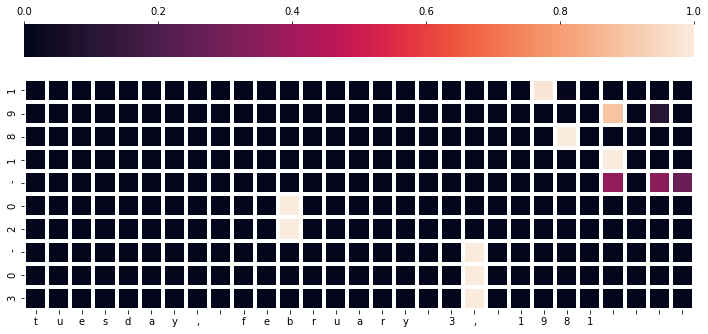

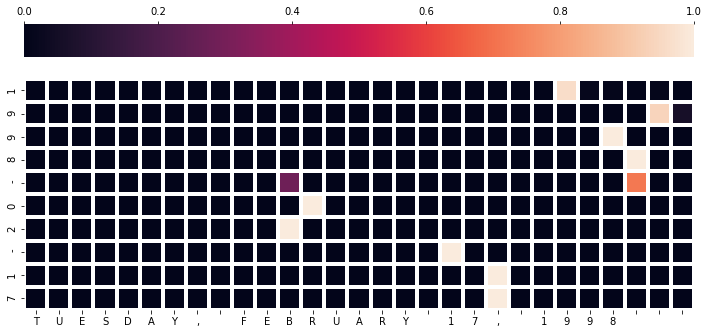

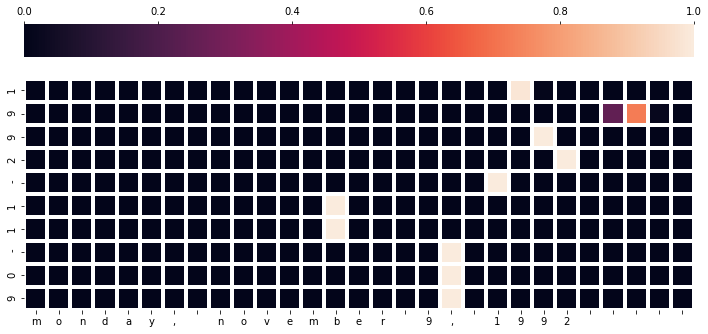

In [96]:
import seaborn as sns 
import matplotlib.pyplot as plt


def plot_attn(test, train_encoder, train_decoder, num_range=3):

  for data in test:
    encoder_inputs = data["input_ids"]
    decoder_ = data["labels"]

    with torch.no_grad():
      hidden, encoder_hs = train_encoder(encoder_inputs)

    decoder_inputs = decoder_[:, :-1]
    decoder_labels = decoder_[:, 1:]

    attn = torch.zeros(decoder_inputs.size()[0], encoder_inputs.size()[1], 1)
    predi = torch.zeros(decoder_inputs.size()[0], 1)

    for i in range(decoder_inputs.size()[1]):
      if i == 0:
        decoder_input = decoder_inputs[:, i]
      with torch.no_grad():
        output, hidden, att = train_decoder(decoder_input, hidden, encoder_hs)
      attn = torch.cat((attn, att), dim=2)
      pred = output.argmax(-1).view(-1)
      decoder_input = output.argmax(-1).view(-1, 1)
      predi = torch.cat((predi, pred.view(-1, 1)), dim=1)

    attn = attn[:, :, 1:].numpy()
    inputs = encoder_inputs.numpy().tolist()
    corr = decoder_[:, 1:].numpy().tolist()

    for i in range(num_range):
      df = pd.DataFrame(attn[i, :, :].reshape(-1, attn.shape[2]),
                        index=[index2word[xx] for xx in inputs[i]],
                        columns=[index2word[tt] for tt in corr[i]],
                        )
      
      
      plt.figure(figsize=(12, 8))
      fig = sns.heatmap(df.T, xticklabels=1, yticklabels=1, square=True, linewidths=3,
                  cbar_kws=dict(use_gridspec=False, location="top"))
      fig = fig.get_figure()
      fig.savefig(f"attention_plot_{i}.png")
      
    break 

plot_attn(test, train_encoder, train_decoder)
    